# Practica Deep Q Learning
Adrian Roldan Rojo

En esta practica vamos a ver como programar un modelo de DQN utilizando python, en nuestro caso utilizaremos la libreria Gym de OpenAI que nos ofrece una coleccion de entornos los cuales podemos utilizar para entrenar nuestro modelo. Ademas utilizaremos las librerias de Pytorch para crear y entrenar nuestra red neuronal. <br>
Las librerias que vamos a utilizar son las siguientes:
* [Torch](https://pytorch.org/), [Torchvision](https://pytorch.org/). Para la creacion y entrenamiento de redes neuronales
* [Numpy](https://numpy.org/). Para la creacion de matrices y calculos matematicos
* [Pillow](https://pillow.readthedocs.io/en/stable/). Para el tratamiento de imagenes
* [Matplotlib](https://matplotlib.org/). Para mostrar graficas
* [Gym](https://gym.openai.com/). Para la creacion de entornos

Si en algun momento de la ejecucion ves que te falta alguna libreria puedes instalarla ejecutando la siguiente celula:

In [1]:
import sys  
!{sys.executable} -m pip install --user <libreria a instalar>

/bin/bash: -c: línea 0: error sintáctico cerca del elemento inesperado `newline'
/bin/bash: -c: línea 0: `/home/adrian/anaconda3/bin/python -m pip install --user <libreria a instalar>'


Lo primero que vamos a hacer es importar todas las librerias necesarias para la ejecucion de nuestros algoritmos:

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import wrappers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

Una vez tengamos todo ya importado vamos a crear nuestro entorno que en nuestro caso sera el entorno CartPole que nos ofrece la libreria Gym. Este entorno consta de un carrito el cual sostiene un palo, el objetivo de este entorno es mantener el equilibrio moviendo el carrito o a la izquierda o a la derecha. <br>
En el siguiente codico crearemos nuestro entorno el cual lo asignaremos a la variable env, ademas declararemos si queremos ejecutar el entrenamiento de redes en CPU o GPU utilizando cuda. Por ultimo, importaremos el display para poder observar como se comporta nuestro entorno

In [3]:
env = gym.make('CartPole-v0').unwrapped

device = torch.device("cpu")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


Vamos a ver como seria nuestro entorno mediante el siguiente codigo, si queremos que se realizen mas o menos acciones tenemos que cambiar el numero dentro de range():

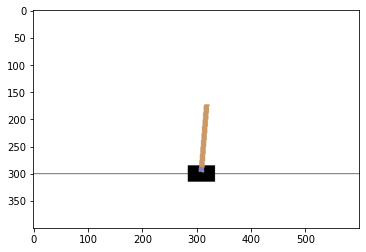

In [18]:
env.reset()

for i in range(25):
   plt.imshow(env.render(mode='rgb_array'))
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(env.action_space.sample()) # Aqui elegimos una accion aleatoria

env.close()

Este entorno podemos modelarlo de dos formas dependiendo de cual sea nuesto estado:
 * Podemos elegir como estado la imagen completa de nuestro entorno, en este caso creariamos un modelo de red convolucional para que procese la imagen
 * Podemos elegir como estado la posicion X la que se encuentra el carrito y la inclincion que presenta el palo


En el caso de este modelo la segunda opcion seria la mas optima ya que nuestra red neuronal seria mas pequeña y al tener menos informacion que filtrar encontraria mas rapido la solucion al problema. Sin embargo, vamos a elegir la primera opcion ya que es la que mas nos interesa para aprender a adaptar otros entornos mas complejos. <br>
En ambas opciones las acciones seran 2:
 * Mover el carrito a la izquierda
 * Mover el carrito a la derecha 


La recompensa en ambas opciones es la misma:
* 1 si el palo se mantiene
* 0 si cae

## REPLAY MEMORY

Vamos a empezar creando la clase replay memory que se encargara de almacenar estados, acciones, recompensas y siguientes estados de las ejecuciones que vaya realizando nuestro entorno. Esto lo hacemos para que a la hora de entrenar nuestra red podamos tomar varios ejemplos aleatorios de esta memoria para poder crear un batch de entrenamiento. <br>
Si no utilizasemos replay memory entrenariamos nuestro modelo unicamente con el estado actual del entorno, por lo que solo se entrenaria con un solo ejemplo.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Modelo de red

Ahora vamos a crear nuestro modelo de red neuronal convolucional. <br>
Este modelo constara de 3 capas convolucionales que se encargaran de procesar la imagen de entrada, posteriormente tendremos 2 capas de neuronas que tomaran como entrada la salida de las capas convolucionales y como capa de salida que tendra el numero de neuronas equivalente al numero de acciones que se requieran, que en nuestro caso seran 2. <br>


Este modelo esta creado con las librerias de Pytorch y consta de dos metodos principales, _init_ que es el que crea e inicia el modelo, el cual toma como entrada la altura y anchura de la imagen que se le pasara a las capas convolucionales y el numero de acciones que tiene nuestro entorno y el metodo _forward_ que es el que se encarga de ejecutar el modelo con la imagen de entrada

In [6]:
class DQN(nn.Module):

    def __init__(self, h, w, output):
        super(DQN, self).__init__()
        self.conv2d_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        def conv2d_size_out(size, kernel_size, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 5), 5), 3)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 5), 5), 3)
        linear_input_size = convw * convh * 32
        
        self.action_layer = nn.Sequential(nn.Linear(linear_input_size, output))
        
    def forward(self, x):
        x = x.to(device)
        x = self.conv2d_layers(x)
        x = torch.flatten(x, 1)
        x = self.action_layer(x)
        return x

## Procesado de imagen

En el siguiente codigo vamos a procesar la imagen que tomara como entrada nuesto modelo de red y guardara nuestra replay memory. Si utilizasemos la imagen tal cual nos la devuelve la libreria Gym tendriamos una imagen muy grande que ocuparia demasiado espacio y tardaria mas en ser entrenada por la red, por lo que la procesamos reduciendo su tamaño mediante get_screen()

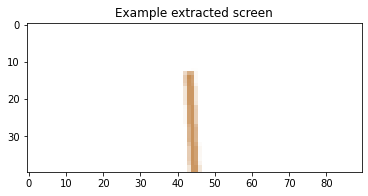

In [19]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # Centro del carrito


def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
env.close()
plt.title('Example extracted screen')
plt.show()


Como vemos la imagen se ha reducido para que ocupe menos espacio

## Inicializacion de datos

En la siguiente celda vamos a iniciar todas las variables necesarias para la ejecucion de nuestro modelo. <br>
Estas variables son las siguientes:
* BATCH_SIZE: Es el tamaño del batch que tomara nuestra red en cada entrenamiento.
* GAMMA: Es el valor que multiplica la recompensa del siguiente estado a la hora de calcular cual sera la recompensa por haber realizado una accion.
* EPS_START, EPS_END, EPS_DECAY: Estos valores indican si a la hora de elegir accion tomamos una accion aleatoria o tomamos la accion elegida por la red EPS_START nos indica cual es la probabilidad inicial de elegir una accion aleatiora. EPS_END nos indica la probabilidad final de elegir una accion aleatoria y EPS_DECAY nos indica la velocidad a la que decae la probabilidad de elegir una accion aleatoria.
* screen_height, screen_width: Nos indica el tamaño que tendra la imagen de entrada a la red.
* n_actions: Nos indica el numero de acciones que hay.
* optimizer: Se trata de la funcion de optimizacion que se encarga de entrenar al modelo de red convolucional.
* memory: Es la variable que guarda la replay memory.
* steps_done: El numero de pasos ya dados, esta variable se utiliza para decaer la probabilidad de accion aleatoria.
* episode_durations: Se trata de un array donde guardaremos la duracion de cada episodio par luego mostralo en una grafica. Un episodio dura desde que empieza nuestro entorno hasta que el palo cae.

A parte de estas variables tambien iniciaremos nuestras dos redes neuronales, la red target y la red policy. Creamos dos redes para añadir estabilidad a la hora de realizar los entrenamientos. La red policy sera la que entrene y elija las acciones y con la target obtendremos cual sera la recompensa del siguiente estado al realizar una accion. Cada cierto tiempo definido con la variable TARGET_UPDATE los pesos de la red policy seran volcados a la red target.

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
env.close()
print(init_screen.shape)
_, _, screen_height, screen_width = init_screen.shape

print(f'Altura de la pantalla: {screen_height}')
print(f'Anchura de la pantalla: {screen_width}')

n_actions = env.action_space.n
print(f'Numero de acciones: {n_actions}')
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000) # El replay memory guarda 10000 estados


steps_done = 0
episode_durations = []

torch.Size([1, 3, 40, 90])
Altura de la pantalla: 40
Anchura de la pantalla: 90
Numero de acciones: 2


## Seleccion de accion

Mediante el siguiente metodo elegiremos que accion realizara nuestro agente, la accion que toma nuestro agente puede ser:
* Una accion aleatoria que sera elegida en funcion del la probabilidad de EPS
* La accion que nos devuelve nuestra red policy

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

## Entrenamiento del modelo

En el siguiente metodo entrenaremos nuestro modelo de red utilizando los estados guardados en la replay memory.<br>
Primero si nuestra replay_memory contiene los suficientes estados cogemos un numero de estos dado por el BATCH_SIZE, estos son los que se utilizaran para el entrenamiento. <br>
Luego le pasaremos a la funcion de perdida la recompensa que espera obtener el modelo al realizar la accion y la recomoensa que ha obtenido mas maxima recompensa que puede obtener del siguiente estado. Una vez calculada la perdida la propagaremos por la red neuronal mediante el optimizer definido anteriormente

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Ejecucion

Ya podemos ejecutar nuestro algoritmo de entrenamiento. Para ello le pasaremos el numero de episodios ue queramos que entrene, luego para cada uno de ellos se entrenara al modelo para cada accion tomada. <br>
Una vez finalizada la ejecucion mostraremos una grafica que nos mostrara la duraciond de cada episodio. <br> Si el numero de episodios es lo suficientemente grande podremos observar que a medida que avanza el entrenamiento la duracion por episodio aumenta

Episodio: 0, duracion: 10
Episodio: 1, duracion: 51
Complete


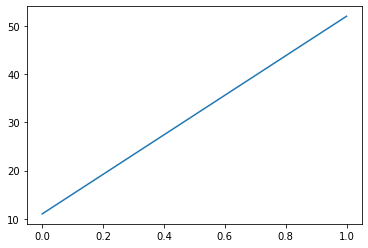

In [11]:
%matplotlib inline
num_episodes = 2
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Seleccionamos y ejecutamos la accion
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # Obtenemos el nuevo estado
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Guardamos los estados, aciones y recompensas en la replay memoryy
        memory.push(state, action, next_state, reward)

        state = next_state

        # Mediante el metodo optimize_model entrenamos el modelo
        optimize_model()
        if done:
            print(f'Episodio: {i_episode}, duracion: {t}')
            episode_durations.append(t + 1)
            break
    # Actualiza la red target
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
# Mostramos las duraciones de los episodios
array = np.array(episode_durations)
plt.plot(array)
plt.show()